In [ ]:
config = {'display-height': 700, # Display pixel height of image for jupyter
         'display-width': 1200, # Display pixel width of image for jupyter
         'image-width':1920, # Actual pixel width of image in directory
         'image-height':939, # Actual pixel height of image in directory
         'hue-lower': 50, # Lower bound hue in HSV space
         'hue-upper': 120, # Upper bound hue in HSV space
         'sat-lower': 40, # Lower bound saturation in HSV space
         'sat-upper': 255, # Upper bound saturation in HSV space
         'value-lower': 140, # Lower bound value in HSV space
         'value-upper': 255, # Upper bound value in HSV space
         'image-dir': '/content/61.PNG', # Relative directory of images
         'area-threshhold': 500, # Area threshhold, detections not meeting this size will be ignored 
         'remove-dupes': True} # Remove duplicates flag, detections contained within other detections will be removed.

In [ ]:
def calc_box_limit(points):
    centroid_width = points[0]
    centroid_height = points[1]
    width_offset = points[2]//2
    height_offset = points[3]//2
    
    box_limits = (centroid_width - width_offset,
                  centroid_width + width_offset,
                  centroid_height - height_offset,
                  centroid_height + height_offset)
    
    return box_limits

In [ ]:
def return_duplicate_indices(box_limits):

    discard = []

    for index, boundary in enumerate(box_limits):

        # If found within ANOTHER box, throw it away, set keep to False
        for outer_index, outer_boundary in enumerate(box_limits):
            if outer_index != index:
                if boundary[0] >= outer_boundary[0] and\
                   boundary[1] <= outer_boundary[1] and\
                   boundary[2] >= outer_boundary[2] and\
                   boundary[3] <= outer_boundary[3]:
                    print('Found duplicate! {} inside of {}'.format(boundary, outer_boundary))
                    discard.append(index)
    return discard

In [ ]:
def display_image_jupyter(image_path):
    return Image(filename = image_path, 
          width = config['display-width'], 
          height = config['display-height'])

In [ ]:
def contours_to_boundingboxes(contours):
    original_detections = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        if area >= config['area-threshhold']:
            original_detections.append((x, y, w, h))
            
    return original_detections

In [ ]:
def print_verify(list_of_something, name):

    print('{} {} have been located.\n'.format(len(list_of_something), name))

    for thing in list_of_something:
        print(thing)

In [ ]:
def find_long_lat_from_filepath(image_path):
    
    filename = image_path.split('/')[-1]
    split = filename.split('_')
    bottom_left_corner = [float(split[4] + '.' + split[5]), float(split[6] + '.' + split[7])]
    top_right_corner = [float(split[8] + '.' + split[9]), float(split[10] + '.' + split[11])]
    
    return bottom_left_corner, top_right_corner

In [ ]:
#files = [config['image-dir'] + filename for filename in os.listdir(config['image-dir'])]

In [ ]:
test_img_path = '/content/29.PNG'

In [ ]:
#display_image_jupyter(test_img_path)

In [ ]:

image = cv2.imread(test_img_path)
print(image.shape)

hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

mask = cv2.inRange(hsv, 
                   (config['hue-lower'], config['sat-lower'], config['value-lower']), 
                   (config['hue-upper'], config['sat-upper'], config['value-upper']))


imask = mask>0
pool_blue = numpy.zeros_like(image, 
                             numpy.uint8)
pool_blue[imask] = image[imask]

contours = cv2.findContours(mask, 
                                  cv2.RETR_TREE, 
                                  cv2.CHAIN_APPROX_SIMPLE)[0]

(103, 212, 3)


In [ ]:

original_detections = contours_to_boundingboxes(contours)

box_limits = list(map(calc_box_limit, original_detections))
    
if config['remove-dupes'] is True:

    discard = return_duplicate_indices(box_limits)

    final_contours = [item for index, item in enumerate(original_detections) if index not in discard]
else:
    discard = []
    final_contours = original_detections

for c in final_contours:
    x, y, w, h = c[0], c[1], c[2], c[3]
    cv2.rectangle(pool_blue,
                  (x,y),
                  (x + w, y + h),
                  (0, 255, 0),2)

In [ ]:
cv2.imwrite('test_result.png', pool_blue)

True

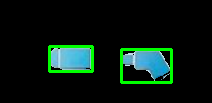

In [ ]:
display_image_jupyter('test_result.png')

In [ ]:
pool_blue.shape

(103, 212, 3)

In [ ]:
print_verify(original_detections, 'original detections')

2 original detections have been located.

(121, 49, 50, 33)
(49, 46, 43, 25)


In [ ]:
print_verify(box_limits, 'box limits')

2 box limits have been located.

(96, 146, 33, 65)
(28, 70, 34, 58)


In [ ]:
print_verify(discard, 'duplicate detections')

0 duplicate detections have been located.



In [ ]:
print_verify(final_contours, 'final contours')

2 final contours have been located.

(121, 49, 50, 33)
(49, 46, 43, 25)


In [ ]:
from operator import itemgetter
classes = ["No Swimming Pool","Swimming Pool"]
def decode_predictions(pred):
    pred = dict(zip(classes, pred.tolist()[0]))
    return sorted(pred.items(), key=itemgetter(1))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model_final=tf.keras.models.load_model('/content/drive/MyDrive/Mosaic/mosaicps2/swimmodel.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def check_for_pool(x,y,w,h,img):
  dim = 64
  if(img.shape[0] < 2*dim or img.shape[1] < 2*dim):
    dim = min(img.shape[0], img.shape[1])//2

  #crop = img[y:y+h, x:x+w]
  # print("POS")
  center_y=y+h//2
  center_x=x+w//2

  crop = img[center_y-dim:center_y+dim, center_x-dim:center_x+dim]

  height=2*dim-crop.shape[0]
  width=2*dim-crop.shape[1]
  if (height!=0 or width!=0):
    crop=img[center_y-dim-height:center_y+dim, center_x-dim-width:center_x+dim]

  height=2*dim-crop.shape[0]
  width=2*dim-crop.shape[1]
  if (height!=0 or width!=0):
    crop=img[center_y-dim-height:center_y+64, center_x-64:center_x+64+width]

  height=2*dim-crop.shape[0]
  width=2*dim-crop.shape[1]
  if (height!=0 or width!=0):
    crop=image[center_y-dim:center_y+dim+height, center_x-dim:center_x+dim+width]

  height=2*dim-crop.shape[0]
  width=2*dim-crop.shape[1]
  if (height!=0 or width!=0):
    crop=img[center_y-dim:center_y+dim+height, center_x-dim-width:center_x+dim]

  #print("Crop before resizing:")
 # cv2_imshow(crop)
 # print(crop.shape)

  if(dim!=64):
    #print("this is executed")
    crop = cv2.resize(crop, (128, 128), cv2.INTER_LINEAR)


  #crop = cv2.resize(crop, (128, 128), interpolation = cv2.INTER_CUBIC)
  #cv2_imshow( crop)
  # plt.figure(figsize=(7,7))
  # img = img.crop((1540, 530, 69, 38))
  # plt.imshow(img)
  # plt.grid(True)
  # plt.xticks([])
  # plt.yticks([])
  #print("CROP ",crop.shape)
  #crop = cv2.resize(crop, (128, 128), interpolation = cv2.INTER_CUBIC)
  if (crop.shape[0]!=crop.shape[1]):
    return [('No Swimming Pool', 1.0),('Swimming Pool', 0.0)]
  img = np.reshape(crop,[1,128,128,3])
  
  ans= decode_predictions(model_final.predict(img))
  return ans

[('No Swimming Pool', 6.739365719908844e-24), ('Swimming Pool', 1.0)]
[('No Swimming Pool', 4.139731386988932e-16), ('Swimming Pool', 1.0)]


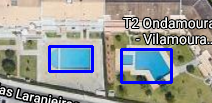

In [ ]:
img = cv2.imread('/content/29.PNG')
markings = img
for i in final_contours:
  ans=check_for_pool(i[0],i[1],i[2],i[3], img)
  for j in ans:
    if (j[0]=='Swimming Pool'):
      temp=j[1]
  if (temp>=0.7):
    x1=i[0]
    y1=i[1]
    x2=i[0]+i[2]
    y2=i[1]+i[3]
    cv2.rectangle(markings, (x1, y1), (x2, y2), (255,0,0), 2)
  print(ans)
cv2_imshow(markings)